## 3. Review tool calls

A human can review and edit the output from the LLM before proceeding. This is particularly critical in applications where the tool calls requested by the LLM may be sensitive or require human oversight.

To add a human approval step to a tool:

1. Use interrupt() in the tool to pause execution.
2. Resume with a Command(resume=...) to continue based on human input.

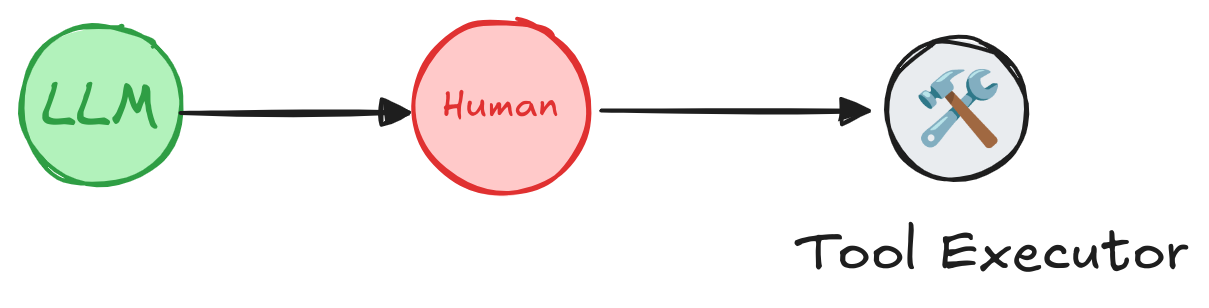

In [ ]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    # highlight-next-line
    response = interrupt(  # (1)!
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

# highlight-next-line
checkpointer = InMemorySaver() # (2)!

agent = create_react_agent(
    model=model,
    tools=[book_hotel],
    # highlight-next-line
    checkpointer=checkpointer, # (3)!
)

1. The [`interrupt` function][langgraph.types.interrupt] pauses the agent graph at a specific node. In this case, we call `interrupt()` at the beginning of the tool function, which pauses the graph at the node that executes the tool. The information inside `interrupt()` (e.g., tool calls) can be presented to a human, and the graph can be resumed with the user input (tool call approval, edit or feedback).
2. The `InMemorySaver` is used to store the agent state at every step in the tool calling loop. This enables [short-term memory](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/memory/add-memory.md#add-short-term-memory) and [human-in-the-loop](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/human_in_the_loop.md) capabilities. In this example, we use `InMemorySaver` to store the agent state in memory. In a production application, the agent state will be stored in a database.
3. Initialize the agent with the `checkpointer`.

Run the agent with the `stream()` method, passing the `config` object to specify the thread ID. This allows the agent to resume the same conversation on future invocations.

In [ ]:
config = {
   "configurable": {
      # highlight-next-line
      "thread_id": "1"
   }
}

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    # highlight-next-line
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content="I'll book a stay at the McKittrick hotel for you.", additional_kwargs={'usage': {'prompt_tokens': 383, 'completion_tokens': 73, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 456}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:0'}, response_metadata={'usage': {'prompt_tokens': 383, 'completion_tokens': 73, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 456}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:0'}, id='run--33d15d46-ecd5-433f-a9c0-389294e983f9-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick hotel'}, 'id': 'toolu_bdrk_012VjQwosrgcv5UCniSi8w4i', 'type': 'tool_call'}], usage_metadata={'input_tokens': 383, 'output_tokens': 73, 'total_t

> You should see that the agent runs until it reaches the interrupt() call, at which point it pauses and waits for human input.


Resume the agent with a `Command(resume=...)` to continue based on human input.

In [4]:
from langgraph.types import Command

for chunk in agent.stream(
    # highlight-next-line
    Command(resume={"type": "accept"}),  # (1)!
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at McKittrick hotel.', name='book_hotel', id='944c7219-809d-4945-9715-d015b0e2ee7e', tool_call_id='toolu_bdrk_019YX6UPagDJn296uC2sV8QK')]}}


{'agent': {'messages': [AIMessage(content="Great! I've successfully booked your stay at the McKittrick hotel. Your reservation has been confirmed.", additional_kwargs={'usage': {'prompt_tokens': 478, 'completion_tokens': 25, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 503}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:0'}, response_metadata={'usage': {'prompt_tokens': 478, 'completion_tokens': 25, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 503}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:

The [interrupt function][langgraph.types.interrupt] is used in conjunction with the [Command][langgraph.types.Command] object to resume the graph with a value provided by the human.


### Add interrupts to any tool

You can create a wrapper to add interrupts to any tool. The example below provides a reference implementation compatible with Agent Inbox UI and Agent Chat UI.

In [6]:
from typing import Callable
from langchain_core.tools import BaseTool, tool as create_tool
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt 
from langgraph.prebuilt.interrupt import HumanInterruptConfig, HumanInterrupt

def add_human_in_the_loop(
    tool: Callable | BaseTool,
    *,
    interrupt_config: HumanInterruptConfig = None,
    ) -> BaseTool:
    
    """Wrap a tool to support human-in-the-loop review.""" 
    if not isinstance(tool, BaseTool):
        tool = create_tool(tool)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept": True,
            "allow_edit": True,
            "allow_respond": True,
        }

    @create_tool(  # (1)!
        tool.name,
        description=tool.description,
        args_schema=tool.args_schema
    )
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            "action_request": {
                "action": tool.name,
                "args": tool_input
            },
            "config": interrupt_config,
            "description": "Please review the tool call"
        }
        # highlight-next-line
        response = interrupt([request])[0]  # (2)!
        # approve the tool call
        if response["type"] == "accept":
            tool_response = tool.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = tool.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response

    return call_tool_with_interrupt

1. This wrapper creates a new tool that calls `interrupt()` **before** executing the wrapped tool.
2. `interrupt()` is using special input and output format that's expected by [Agent Inbox UI](https://github.com/langchain-ai/agent-inbox):
    - a list of [`HumanInterrupt`][langgraph.prebuilt.interrupt.HumanInterrupt] objects is sent to `AgentInbox` render interrupt information to the end user
    - resume value is provided by `AgentInbox` as a list (i.e., `Command(resume=[...])`)

You can use the `add_human_in_the_loop` wrapper to add `interrupt()` to any tool without having to add it *inside* the tool:

In [7]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent

# highlight-next-line
checkpointer = InMemorySaver()

def book_hotel(hotel_name: str):
   """Book a hotel"""
   return f"Successfully booked a stay at {hotel_name}."


agent = create_react_agent(
    model=model,
    tools=[
        # highlight-next-line
        add_human_in_the_loop(book_hotel), # (1)!
    ],
    # highlight-next-line
    checkpointer=checkpointer,
)

config = {"configurable": {"thread_id": "1"}}

# Run the agent
for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    # highlight-next-line
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content="I'll book a stay at the McKittrick hotel for you.", additional_kwargs={'usage': {'prompt_tokens': 383, 'completion_tokens': 73, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 456}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:0'}, response_metadata={'usage': {'prompt_tokens': 383, 'completion_tokens': 73, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 456}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:0'}, id='run--abce4fc3-2813-4308-aa3a-43ddd0383cd6-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick hotel'}, 'id': 'toolu_bdrk_013XHrDMCr7jwN52XD9dFquy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 383, 'output_tokens': 73, 'total_t

> 
> 
1. The `add_human_in_the_loop` wrapper is used to add `interrupt()` to the tool. This allows the agent to pause execution and wait for human input before proceeding with the tool call.

> You should see that the agent runs until it reaches the interrupt() call, at which point it pauses and waits for human input.
> 

Resume the agent with a `Command(resume=...)` to continue based on human input.

In [8]:
from langgraph.types import Command 

for chunk in agent.stream(
    # highlight-next-line
    Command(resume=[{"type": "accept"}]),
    # Command(resume=[{"type": "edit", "args": {"args": {"hotel_name": "McKittrick Hotel"}}}]),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at McKittrick hotel.', name='book_hotel', id='f4695981-9b6b-4829-b694-a449eac04892', tool_call_id='toolu_bdrk_013XHrDMCr7jwN52XD9dFquy')]}}


{'agent': {'messages': [AIMessage(content="Great! I've successfully booked your stay at the McKittrick hotel. Your reservation has been confirmed.", additional_kwargs={'usage': {'prompt_tokens': 478, 'completion_tokens': 25, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 503}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:0'}, response_metadata={'usage': {'prompt_tokens': 478, 'completion_tokens': 25, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 503}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'us.anthropic.claude-sonnet-4-20250514-v1:0', 'model_name': 'us.anthropic.claude-sonnet-4-20250514-v1:

## 4. Validate human input

If you need to validate the input provided by the human within the graph itself (rather than on the client side), you can achieve this by using multiple interrupt calls within a single node.




In [17]:

from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver


In [18]:

# Define graph state
class State(TypedDict):
    age: int

# Node that asks for human input and validates it
def get_valid_age(state: State) -> State:
    prompt = "Please enter your age (must be a non-negative integer)."

    while True:
        user_input = interrupt(prompt)

        # Validate the input
        try:
            age = int(user_input)
            if age < 0:
                raise ValueError("Age must be non-negative.")
            break  # Valid input received
        except (ValueError, TypeError):
            prompt = f"'{user_input}' is not valid. Please enter a non-negative integer for age."

    return {"age": age}

# Node that uses the valid input
def report_age(state: State) -> State:
    print(f"✅ Human is {state['age']} years old.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("get_valid_age", get_valid_age)
builder.add_node("report_age", report_age)

builder.set_entry_point("get_valid_age")
builder.add_edge("get_valid_age", "report_age")
builder.add_edge("report_age", END)

# Create the graph with a memory checkpointer
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

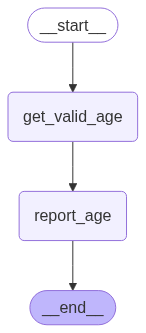

In [19]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [20]:

# Run the graph until the first interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])  # First prompt: "Please enter your age..."

[Interrupt(value='Please enter your age (must be a non-negative integer).', resumable=True, ns=['get_valid_age:bac7d878-430b-36b7-d712-12d46fa3e516'])]


In [21]:
# Simulate an invalid input (e.g., string instead of integer)
result = graph.invoke(Command(resume="not a number"), config=config)
print(result["__interrupt__"])  # Follow-up prompt with validation message


[Interrupt(value="'not a number' is not valid. Please enter a non-negative integer for age.", resumable=True, ns=['get_valid_age:bac7d878-430b-36b7-d712-12d46fa3e516'])]


In [22]:
# Simulate a second invalid input (e.g., negative number)
result = graph.invoke(Command(resume="-10"), config=config)
print(result["__interrupt__"])  # Another retry


[Interrupt(value="'-10' is not valid. Please enter a non-negative integer for age.", resumable=True, ns=['get_valid_age:bac7d878-430b-36b7-d712-12d46fa3e516'])]


In [23]:
# Provide valid input
final_result = graph.invoke(Command(resume="25"), config=config)
print(final_result)  # Should include the valid age


✅ Human is 25 years old.
{'age': 25}
